### Cargar un modelo Word2Vec pre-entrenado para el español

ver: https://github.com/dccuchile/spanish-word-embeddings

In [1]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("data/SBW-vectors-300-min5.bin.gz", binary=True) 

In [2]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="data/luis/FN_PLU_2017-2021_igram_v1.csv"
df = pd.read_csv(dataset)



In [4]:
noticias = df.Description[df["tipoI"].isin([2,3])]

len(noticias)

633

In [5]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens


In [6]:
documents=[]
for noticia in noticias:
    documents.append(spacy_tokenizer(noticia))

In [7]:
etm_documents=[]
for document in documents:
    etm_documents.append(" ".join(document))

In [8]:
from embedded_topic_model.utils import preprocessing
import json

# Preprocessing the dataset
diccionario, train_dataset,test_dataset, = preprocessing.create_etm_datasets(
    etm_documents, 
    min_df=0.01, 
    max_df=0.75, 
    train_size=0.85, 
)



In [9]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance
perp =[]
numk = range(1,10)
for k in numk:
    etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=k,
        epochs=200,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

    etm_instance.fit(train_dataset, test_dataset)
    perp.append(etm_instance._perplexity(test_dataset))



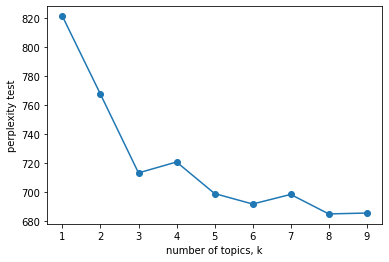

In [10]:
import matplotlib.pyplot as plt
plt.plot(numk, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity test')
plt.xticks(numk)
plt.show()

In [11]:
from embedded_topic_model.models.etm import ETM
etm_instance = ETM(
       diccionario,
        embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
        num_topics=3,
        epochs=500,
        debug_mode=False,
        eval_perplexity=True,
        train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
    )

etm_instance.fit(train_dataset, test_dataset)

In [12]:
import numpy as np
## extrayendo resultados del análisis de tópicos
topics = etm_instance.get_topics(20)
dist = etm_instance.get_document_topic_dist()
d_topic = etm_instance.get_topic_word_dist()

##creando las entradas para visualización
true_k=3
nDoc = len(dist)
nVocab = len(diccionario)
dist_doc = np.array(dist).reshape(nDoc,true_k)
dist_topic= np.array(d_topic).reshape(true_k,nVocab)
print(topics)

[['falso', 'social', 'noticia', 'información', 'red', 'desinformación', 'leer', 'medio', 'completo', 'facebook', 'pandemia', 'salud', 'coronavirus', 'difundir', 'vacuna', 'dato', 'mensaje', 'plataforma', 'comunicación', 'mundo'], ['fake', 'new', 'link', 'bio', 'chile', 'presidente', 'video', 'candidato', 'kast', 'campaña', 'presidencial', 'entrevista', 'detalle', 'elección', 'boric', 'electoral', 'político', 'diputado', 'trump', 'señalar'], ['persona', 'él', 'año', 'país', 'chile', 'público', 'gobierno', 'caso', 'nacional', 'carabinero', 'artículo', 'investigación', 'mujer', 'tiempo', 'mes', 'dicho', 'haber', 'situación', 'internacional', 'grupo']]


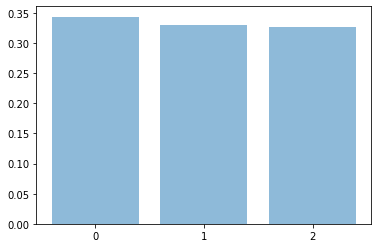

[0.048818506, 0.037875496, 0.037003435, 0.03452073, 0.030690284, 0.021534877, 0.019055024, 0.012481975, 0.01175409, 0.010450889, 0.010090686, 0.00881384, 0.008700474, 0.008699578, 0.008469868]


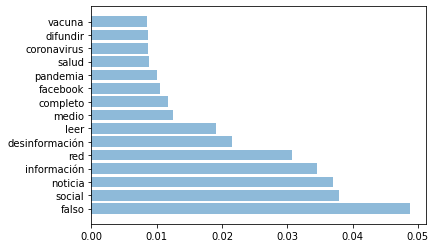

[0.03450576, 0.032242935, 0.022401383, 0.01804461, 0.01739015, 0.014172294, 0.011937973, 0.011600297, 0.009802443, 0.009722098, 0.009308732, 0.008323468, 0.008309886, 0.008266389, 0.007871144]


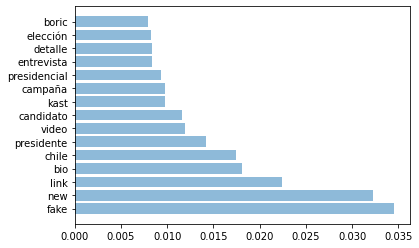

[0.014801302, 0.0141506, 0.013553499, 0.012981779, 0.012946876, 0.008727348, 0.0082788365, 0.007567074, 0.007275041, 0.0061571044, 0.005536244, 0.005406812, 0.005218026, 0.0051752278, 0.00481501]


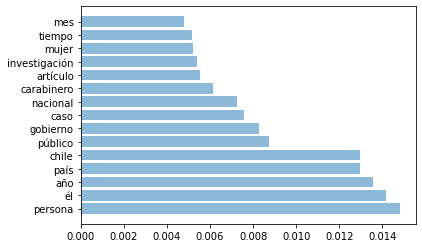

In [13]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import matplotlib.pyplot as plt
import numpy as np

dist_sum = sum(dist_doc)/nDoc
w=np.arange(0,true_k)
plt.bar(w,height=dist_sum,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
#plt.bar(w,height=dist_doc[51],alpha=0.5,tick_label=w)
#show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(dist_topic):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    print(d)
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()



In [14]:
doc_l = np.zeros(len(train_dataset['counts']))
term_f= np.zeros(len(diccionario))
for i in range(0,len(train_dataset['counts'])):
        for j in range(0,len(train_dataset['counts'][i])):
                js = train_dataset['tokens'][i][j]
             
                term_f[js] = term_f[js] + train_dataset['counts'][i][j]
                doc_l[i] = doc_l[i]+ train_dataset['counts'][i][j]

In [16]:
import pyLDAvis
prepared = pyLDAvis.prepare(doc_lengths = doc_l,
                        vocab = diccionario,
                        term_frequency = term_f,
                        topic_term_dists = dist_topic,
                        doc_topic_dists = dist_doc)
pyLDAvis.display(prepared)

In [18]:
topic_coherence = etm_instance.get_topic_coherence()
print(topic_coherence)
topic_diversity = etm_instance.get_topic_diversity()
print(topic_diversity)
print(etm_instance._perplexity(test_dataset))

0.09516610729985647
0.9866666666666667
698.7


/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its

/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/eliana/anaconda3/envs/etmEnv/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by its